# Demonstration of distribution reweighting

**hep_ml.reweight** contains methods to reweight distributions. 
Typically we use reweighting of monte-carlo to fight drawbacks of simulation, though there are many applications.

In this example we reweight multidimensional distibutions: `original` and `target`, the aim is to find new weights for original distribution, such that these multidimensional distributions will coincide. 

Here we have a __toy example__ without a real physics meaning.

Pay attention: equality of distibutions for each feature $\neq$ equality of multivariate distributions.

All samples are divided into **training** and **validation** part. Training part is used to fit reweighting rule and test part is used to estimate reweighting quality.

In [1]:
%matplotlib inline

import numpy
import uproot
from matplotlib import pyplot as plt

from hep_ml import reweight

### Downloading data

In [2]:
storage = "https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/"
!wget -O ../data/MC_distribution.root -nc $storage/MC_distribution.root?raw=true
!wget -O ../data/RD_distribution.root -nc $storage/RD_distribution.root?raw=true

File ‘../data/MC_distribution.root’ already there; not retrieving.
File ‘../data/RD_distribution.root’ already there; not retrieving.


In [3]:
columns = ["hSPD", "pt_b", "pt_phi", "vchi2_b", "mu_pt_sum"]

# Use uproot instead of root_numpy
with uproot.open("../data/MC_distribution.root") as file:
    tree = file[file.keys()[0]]  # Get first tree
    original = tree.arrays(columns, library="pd")

with uproot.open("../data/RD_distribution.root") as file:
    tree = file[file.keys()[0]]  # Get first tree
    target = tree.arrays(columns, library="pd")

original_weights = numpy.ones(len(original))

### prepare train and test samples

* train part is used to train reweighting rule
* test part is used to evaluate reweighting rule comparing the following things: 
    * Kolmogorov-Smirnov distances for 1d projections
    * n-dim distibutions using ML (see below).

In [4]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = numpy.ones(len(original_train))
original_weights_test = numpy.ones(len(original_test))

In [5]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {"bins": 100, "density": True, "alpha": 0.7}


def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print(
            "KS over ",
            column,
            " = ",
            ks_2samp_weighted(
                original[column],
                target[column],
                weights1=new_original_weights,
                weights2=numpy.ones(len(target), dtype=float),
            ),
        )

### Notice:
Setting `density=True` in `hist_settings` above means that the histograms will be drawn normalized below, so that the area under each histogram integrates to 1. This can obscure the fact that the weights produced by `predict_weights` are not normalized; if you want the number of effective events to be the same after reweighting, you must renormalize the weights manually--see the `reweight` documentation.


## Original distributions
KS = Kolmogorov-Smirnov distance

In [6]:
# pay attention, actually we have very few data
len(original), len(target)

(1000000, 21441)

KS over  hSPD  =  0.5203540728277889
KS over  pt_b  =  0.21639364439970188
KS over  pt_phi  =  0.4020113592414034
KS over  vchi2_b  =  0.40466385087324064
KS over  mu_pt_sum  =  0.21639364439970188


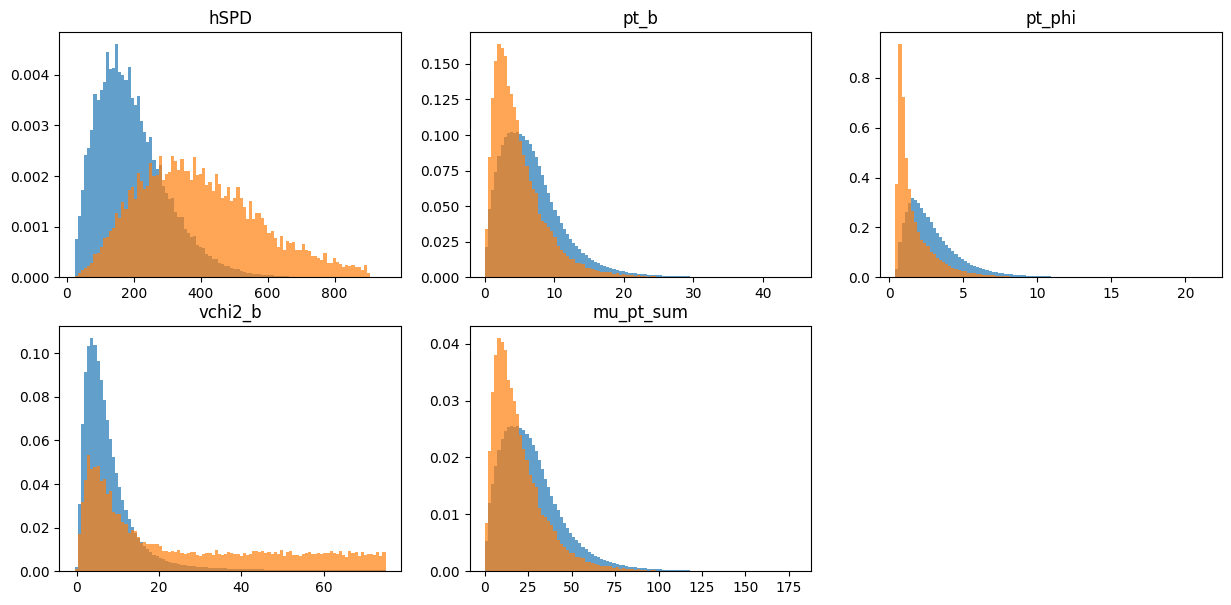

In [7]:
draw_distributions(original, target, original_weights)

### train part of original distribution

KS over  hSPD  =  0.5234655124378005
KS over  pt_b  =  0.2147509950228308
KS over  pt_phi  =  0.40324685572155894
KS over  vchi2_b  =  0.40211346268053644
KS over  mu_pt_sum  =  0.2147509950228308


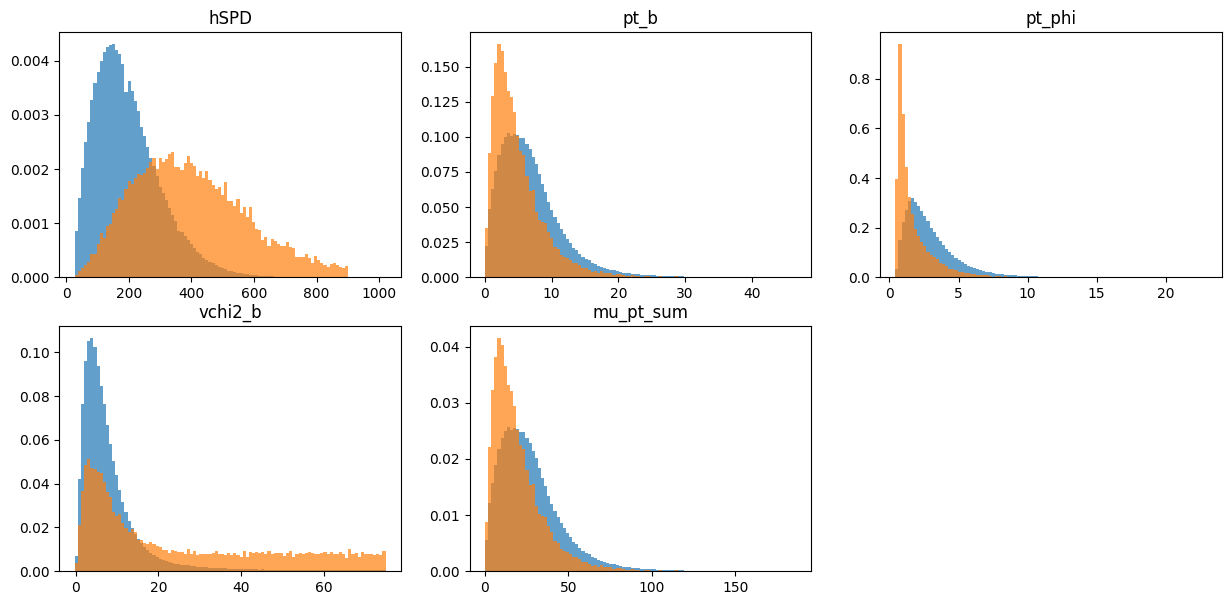

In [8]:
draw_distributions(original_train, target_train, original_weights_train)

### test part for target distribution

KS over  hSPD  =  0.5111867502331762
KS over  pt_b  =  0.22264861294504523
KS over  pt_phi  =  0.4002473766087341
KS over  vchi2_b  =  0.41376927774748923
KS over  mu_pt_sum  =  0.22264861294504523


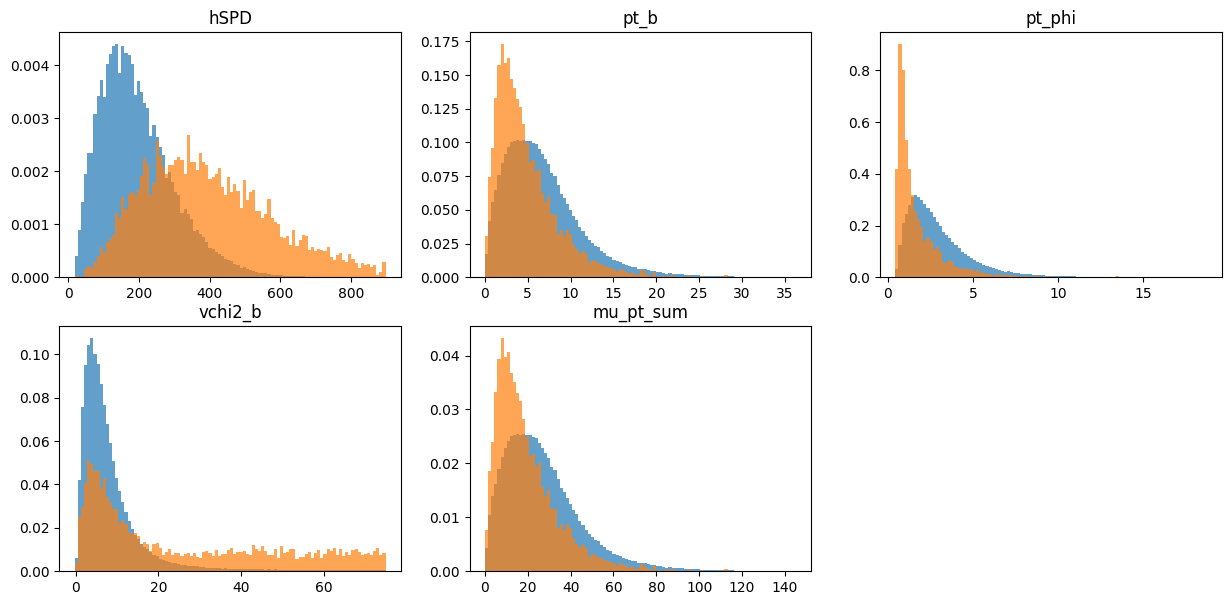

In [9]:
draw_distributions(original_test, target_test, original_weights_test)

# Bins-based reweighting in n dimensions
Typical way to reweight distributions is based on bins.

KS over  hSPD  =  0.2782959755293173
KS over  pt_b  =  0.09599681751737577
KS over  pt_phi  =  0.15531701346199328
KS over  vchi2_b  =  0.26537709242055496
KS over  mu_pt_sum  =  0.09599681751737577


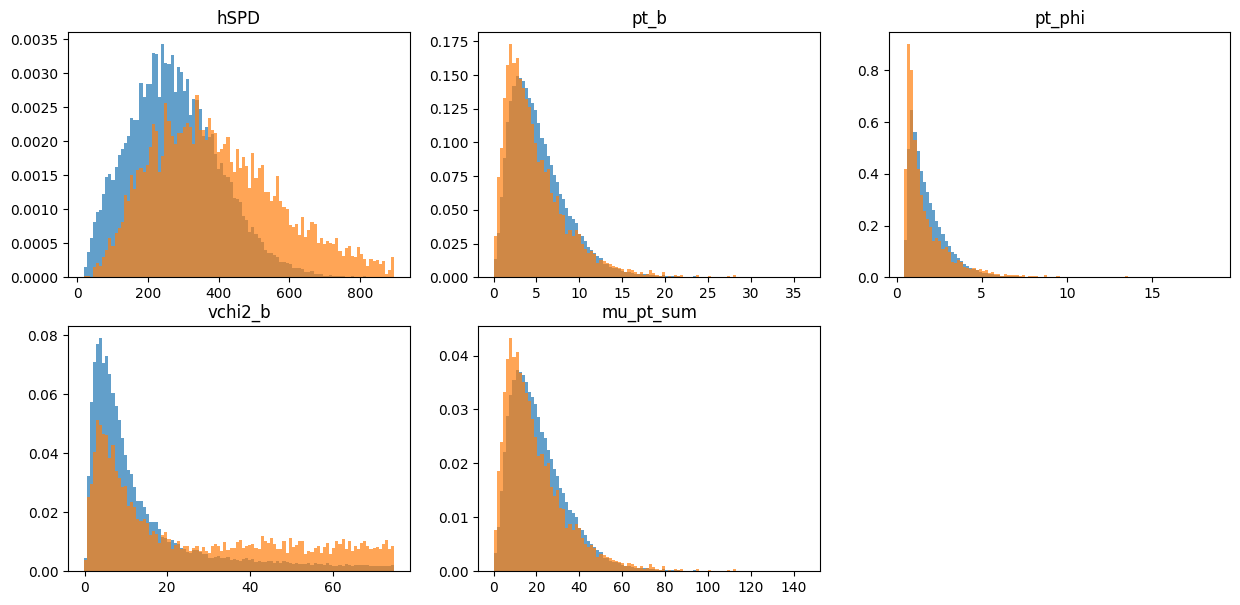

In [10]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.0)
bins_reweighter.fit(original_train, target_train)

bins_weights_test = bins_reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, bins_weights_test)

# Gradient Boosted Reweighter

This algorithm is inspired by gradient boosting and is able to fight curse of dimensionality.
It uses decision trees and special loss functiion (**ReweightLossFunction**).

**GBReweighter** supports negative weights (to reweight MC to splotted real data).

KS over  hSPD  =  0.02997659737781444
KS over  pt_b  =  0.03769307532097915
KS over  pt_phi  =  0.02103431059835592
KS over  vchi2_b  =  0.03631941905640923
KS over  mu_pt_sum  =  0.03769307532097915


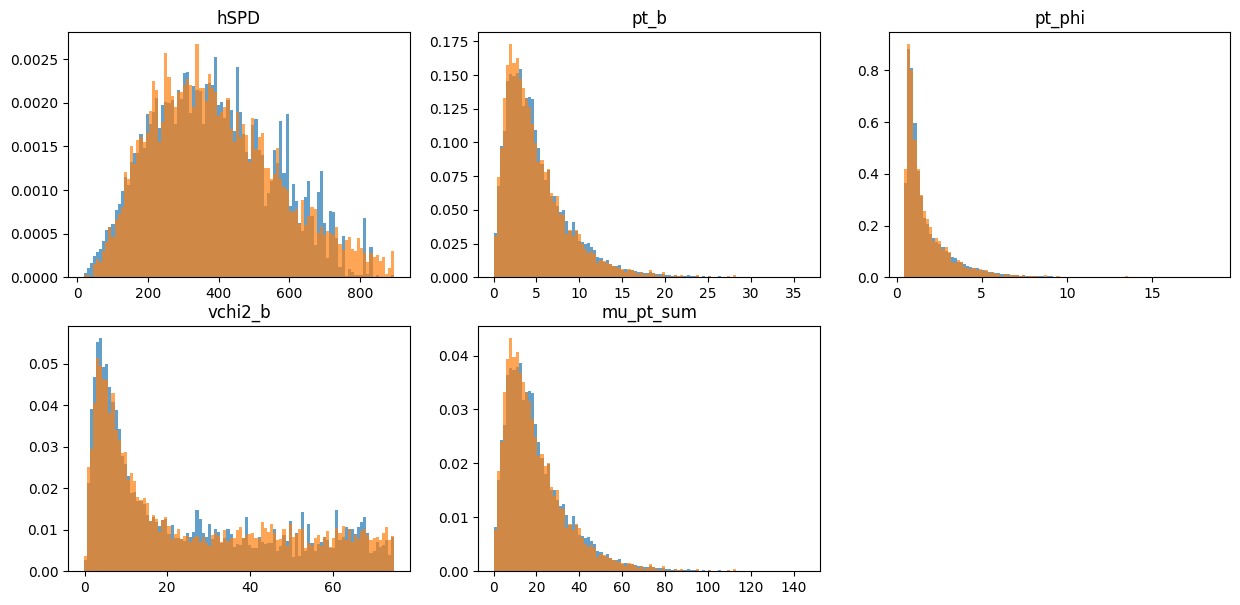

In [11]:
reweighter = reweight.GBReweighter(
    n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={"subsample": 0.4}
)
reweighter.fit(original_train, target_train)

gb_weights_test = reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, gb_weights_test)

## Comparing some simple expressions:
the most interesting is checking some other variables in multidimensional distributions (those are expressed via original variables).

In [12]:
def check_ks_of_expression(expression):
    col_original = original_test.eval(expression, engine="python")
    col_target = target_test.eval(expression, engine="python")
    w_target = numpy.ones(len(col_target), dtype="float")
    print(
        "No reweight   KS:",
        ks_2samp_weighted(col_original, col_target, weights1=original_weights_test, weights2=w_target),
    )
    print(
        "Bins reweight KS:", ks_2samp_weighted(col_original, col_target, weights1=bins_weights_test, weights2=w_target)
    )
    print("GB Reweight   KS:", ks_2samp_weighted(col_original, col_target, weights1=gb_weights_test, weights2=w_target))

In [13]:
check_ks_of_expression("hSPD")

No reweight   KS: 0.5111867502331762
Bins reweight KS: 0.2782959755293173
GB Reweight   KS: 0.02997659737781444


In [14]:
check_ks_of_expression("hSPD * pt_phi")

No reweight   KS: 0.08816943443405004
Bins reweight KS: 0.12293206732914022
GB Reweight   KS: 0.013721291559250559


In [15]:
check_ks_of_expression("hSPD * pt_phi * vchi2_b")

No reweight   KS: 0.37611764708143863
Bins reweight KS: 0.27720502041756984
GB Reweight   KS: 0.02887946824692733


In [16]:
check_ks_of_expression("pt_b * pt_phi / hSPD ")

No reweight   KS: 0.4810264484236698
Bins reweight KS: 0.2825995685508179
GB Reweight   KS: 0.028335827928861745


In [17]:
check_ks_of_expression("hSPD * pt_b * vchi2_b / pt_phi")

No reweight   KS: 0.4966655015862845
Bins reweight KS: 0.2933313778461959
GB Reweight   KS: 0.023589799816173818


# GB-discrimination
let's check how well a classifier is able to distinguish these distributions. ROC AUC is taken as a measure of quality.

For this puprose we split the data into train and test, then we train a classifier do distinguish these distributions.
If ROC AUC = 0.5 on test, distibutions are identical, if ROC AUC = 1.0, they are ideally separable.

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

data = numpy.concatenate([original_test, target_test])
labels = numpy.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights["original"] = original_weights_test
weights["bins"] = bins_weights_test
weights["gb_weights"] = gb_weights_test


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.8872045343399906
bins 0.7935974689667249
gb_weights 0.5300201150346089


# Folding reweighter

With `FoldingReweighter` one can simpler do cross-validation and in the end obtain unbiased weights for the whole original sample

KFold prediction using folds column
KS over  hSPD  =  0.049188322905358794
KS over  pt_b  =  0.029601582141920657
KS over  pt_phi  =  0.029232692415086525
KS over  vchi2_b  =  0.03178958185238728
KS over  mu_pt_sum  =  0.029601582141920657


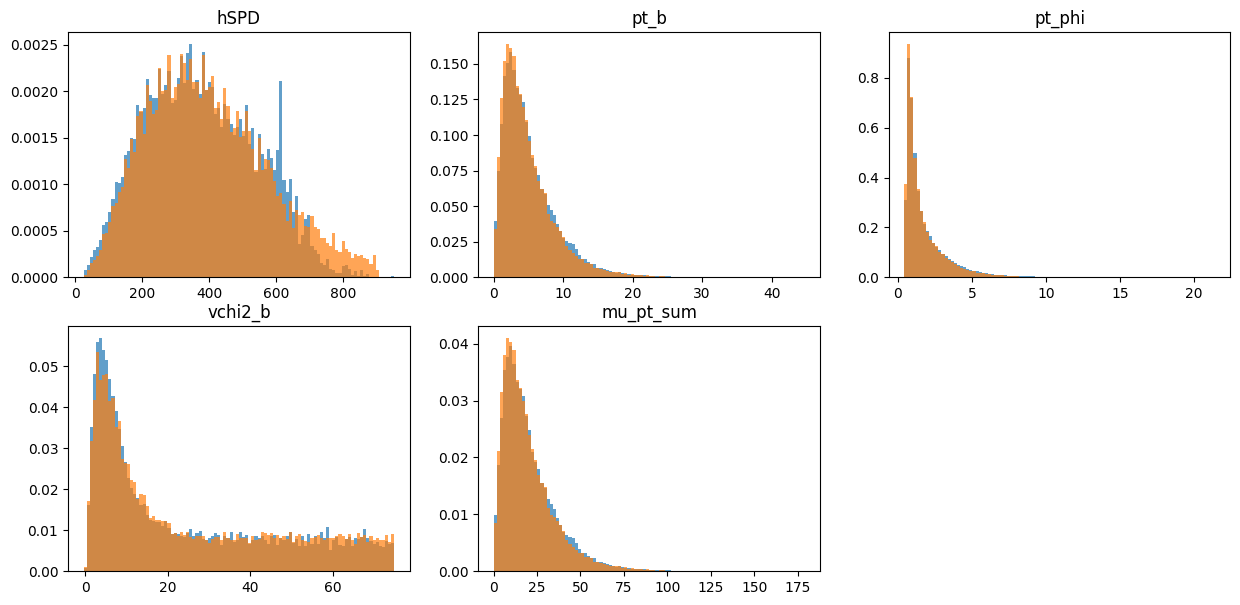

In [19]:
# define base reweighter
reweighter_base = reweight.GBReweighter(
    n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={"subsample": 0.4}
)
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; rewighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

draw_distributions(original, target, folding_weights)

### GB discrimination for reweighting rule

In [20]:
data = numpy.concatenate([original, target])
labels = numpy.array([0] * len(original) + [1] * len(target))

weights = {}
weights["original"] = original_weights
weights["2-folding"] = folding_weights


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.8876817158042778
2-folding 0.5602450665934032
